# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [25]:
#import libraries
import pandas as pd
import datetime
import numpy as np


from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DateType, StringType
from pyspark.sql.functions import date_format, hour, asc, desc, col, avg, count, isnan, when
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler, PCA, ChiSqSelector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

In [26]:
#create a Spark session

spark = SparkSession \
.builder \
.appName('Sparkify') \
.getOrCreate()

In [27]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '4502473930b8'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '33527'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1609006289232')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [28]:
path='mini_sparkify_event_data.json'
data = spark.read.json(path)

In [29]:
###Number of entries and data type of columns 
data.printSchema()
data.take(5)
print("There are", data.count(), "entries")
data.show(n=5)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

There are 286500 entries
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastN

In [30]:
#Non signed in activites or non values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
data.filter(data.userId == "").count()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



8346

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [56]:
#Unique values in "page" column
data.select("page").dropDuplicates().sort("page").show(80)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [32]:
#Number of unique userIds
data.filter(data.userId != "").select("userId").distinct().count()   

225

+----+
|hour|
+----+
|   7|
|  15|
|  11|
|   3|
|   8|
|  22|
|  16|
|   0|
|   5|
|  18|
|  17|
|   6|
|  19|
|  23|
|   9|
|   1|
|  20|
|  10|
|   4|
|  12|
+----+
only showing top 20 rows

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows

root
 |-- hour: string (nullable = true)
 |-- count: long (nullable = false)



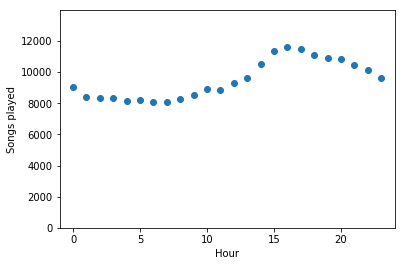

In [33]:
#Number of songs played by hours
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
data=data.withColumn("hour", get_hour(data.ts))
data.select("hour").dropDuplicates().show()
songs_in_hour = data.filter(data.page == "NextSong").groupby(data.hour).count().orderBy(data.hour.cast("float"))
songs_in_hour.show()
songs_in_hour.printSchema()
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

#Plotting of songs played by hours
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [34]:
#Remove rows without userId
data_valid = data.filter(data["userId"] != "")
data_valid.count()

278154

In [35]:
#Identify downgrade activities
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
data_valid = data_valid.withColumn("downgraded", flag_downgrade_event("page"))

   downgraded_user gender  count
0             True      F     28
1            False      M    100
2             True      M     21
3            False      F     76


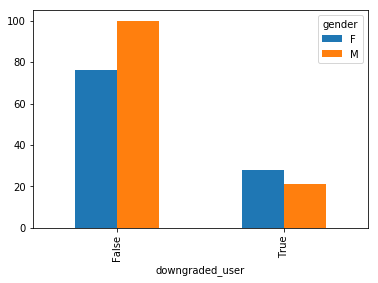

In [36]:
#See gender of users who have submitted to be downgraded 
downgrade_list = data_valid.filter(data_valid.page=="Submit Downgrade" ).select("userId").distinct()
downgraded_users = [(row['userId']) for row in downgrade_list.collect()]
data_valid = data_valid.withColumn('downgraded_user', data_valid.userId.isin(downgraded_users))
down_count=data_valid.dropDuplicates(["userId", "gender"]).groupby(["downgraded_user", "gender"]).count().toPandas()
print(down_count)
down_count.pivot(index='downgraded_user', columns='gender', values='count').plot(kind='bar')

  level gender   count
0  free      M   26049
3  free      F   29672
1  paid      M   97527
2  paid      F  124906


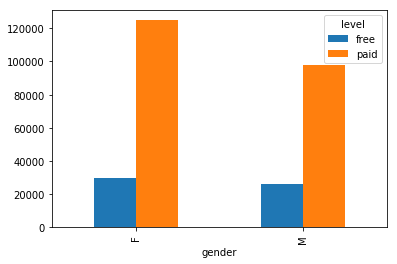

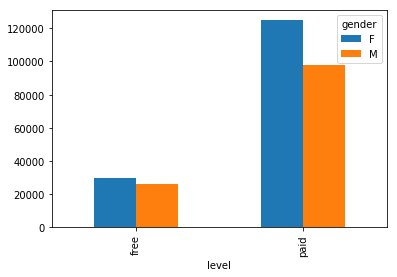

In [37]:
#Activities by gender and level (free/paid)
plot_count = data_valid.select('userId','level','gender').groupby('level','gender').count().toPandas().sort_values(by='count')
print(plot_count)
plot_count.pivot(index='gender', columns='level', values='count').plot(kind='bar')
plot_count.pivot(index='level', columns='gender', values='count').plot(kind='bar')
###Showed more females with paid account 

    level                                          userAgent  count
37   free  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...      5
53   free  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...     25
11   free  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; r...     35
73   paid  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...     37
100  free  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...     62
47   free  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3...     70
23   free  Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...     76
44   free  "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...     97
20   free  "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....    105
67   free  Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...    141
25   free  Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko...    148
32   paid  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...    154
81   free  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...    186
71   free  "Mozilla/5.0 (Macintosh; Intel Mac OS

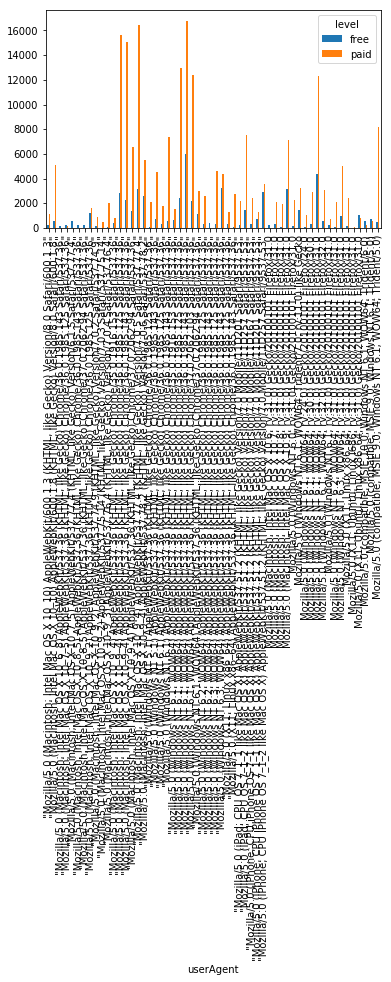

In [38]:
#Activites by userAgent and level (free/paid)
plot_count = data_valid.select('userId','level','userAgent').groupby('level','userAgent').count().toPandas().sort_values(by='count')
print(plot_count)
plot_count.pivot(index='userAgent', columns='level', values='count').plot(kind='bar')


In [39]:
#Most played artist and their number of songs
songs_by_artist = data_valid.filter(data_valid.page == 'NextSong').select('Artist').groupBy('Artist')\
    .agg({'Artist':'count'}).withColumnRenamed('count(Artist)', 'Artistcount').sort(desc('Artistcount'))
songs_by_artist.show()

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
|      The Black Keys|       1125|
|                Muse|       1090|
|       Justin Bieber|       1044|
|        Jack Johnson|       1007|
|              Eminem|        953|
|           Radiohead|        884|
|     Alliance Ethnik|        876|
|               Train|        854|
|        Taylor Swift|        840|
|         OneRepublic|        828|
|         The Killers|        822|
|         Linkin Park|        787|
|         Evanescence|        781|
|            Harmonia|        729|
|       Guns N' Roses|        713|
+--------------------+-----------+
only showing top 20 rows



In [40]:
#Number of songs listened by users between visiting Home pages and their average songs played per period
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = data.filter((data.page == 'NextSong') | (data.page == 'Home')) \
    .select('userId', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

#cusum.show(80)

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userId', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show(80)

play_count_period=cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userId', 'period') \
    .agg({'period':'count'}) \
    .groupBy('userId').agg({'count(period)':'avg'})

print(play_count_period.show(20))


+------------------+
|avg(count(period))|
+------------------+
| 23.60389072847682|
+------------------+

+------+------------------+
|userId|avg(count(period))|
+------+------------------+
|100010|22.916666666666668|
|200002|             19.35|
|   125|               8.0|
|   124|  24.4251497005988|
|    51|29.319444444444443|
|     7|13.636363636363637|
|    15|21.266666666666666|
|    54| 24.92105263157895|
|   155|29.285714285714285|
|100014|            32.125|
|   132| 24.71794871794872|
|   154|              14.0|
|   101|24.958333333333332|
|    11|17.486486486486488|
|   138|30.895522388059703|
|300017| 24.54054054054054|
|100021|            14.375|
|    29|25.233333333333334|
|    69|           23.4375|
|   112| 16.53846153846154|
+------+------------------+
only showing top 20 rows

None


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.


churned: 23.11%
   userId  sum(churned)
0  100010             0
1  200002             0
2     125             1
3      51             1
4     124             0
5       7             0
6      54             1
7      15             0
8     155             0
9     132             0


Text(0,0.5,'Number of Users')

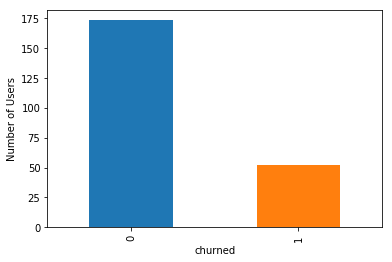

In [41]:
#Identify number of churned users; the number and Percentage of users chruned
churned_col = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = data_valid.withColumn("churned", churned_col('page'))
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churn_count=df_churned.groupby("userId").agg({"churned": "sum"}).toPandas()
print(churn_count.head(10))
churn_count['sum(churned)'].value_counts().plot(kind='bar')
plt.xlabel("churned")
plt.ylabel('Number of Users')

In [42]:
#Amount of time spent by users
length = df_churned.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
print(length.show(5))

+------+------------------+
|userId|            length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows

None


In [43]:
#Number of Thumbs Up and Thumbs Down by Users
thumbs_up = df_churned.filter(df_churned["page"] == 'Thumbs Up').groupby('userId').count()
print(thumbs_up.show(5))
thumbs_down = df_churned.filter(df_churned["page"] == 'Thumbs Down').groupby('userId').count()
print(thumbs_down.show(5))

+------+-----+
|userId|count|
+------+-----+
|100010|   17|
|200002|   21|
|    51|  100|
|   124|  171|
|     7|    7|
+------+-----+
only showing top 5 rows

None
+------+-----+
|userId|count|
+------+-----+
|100010|    5|
|200002|    6|
|    51|   21|
|   124|   41|
|     7|    1|
+------+-----+
only showing top 5 rows

None


In [44]:
#Number of songs added per user; their upgrade submission, downgrad submission and number of clicking to next song
play_list = df_churned.filter(df_churned["page"] == 'Add to Playlist').groupby('userId').count()
upgrade = df_churned.filter(df_churned["page"] == 'Submit Upgrade').groupby('userId').count()
downgrade = df_churned.filter(df_churned["page"] == 'Submit Downgrade').groupby('userId').count()
song = df_churned.filter(df_churned["page"] == 'NextSong').groupby('userId').count()
print(song.show(5))

+------+-----+
|userId|count|
+------+-----+
|100010|  275|
|200002|  387|
|   125|    8|
|    51| 2111|
|   124| 4079|
+------+-----+
only showing top 5 rows

None


In [45]:
#Convert gender into numerical values
con_gender = udf(lambda x: 1 if x=="F" else 0, IntegerType())
user_gender = data_valid.select(['userId', 'gender']).dropDuplicates(['userId']).withColumn('User_gender', con_gender('gender').cast(IntegerType()))
user_gender.show(5)

+------+------+-----------+
|userId|gender|User_gender|
+------+------+-----------+
|100010|     F|          1|
|200002|     M|          0|
|   125|     M|          0|
|   124|     F|          1|
|    51|     M|          0|
+------+------+-----------+
only showing top 5 rows



   userId  churned  play_list  upgrade  downgrade  thumbs_up  thumbs_down  \
0  100010        0        7.0      NaN        NaN       17.0          5.0   
1  200002        0        8.0      1.0        NaN       21.0          6.0   
2     125        1        NaN      NaN        NaN        NaN          NaN   
3      51        1       52.0      NaN        NaN      100.0         21.0   
4     124        0      118.0      NaN        NaN      171.0         41.0   

         length  song  play_per_period_avg  
0  6.694090e+04   275            22.916667  
1  9.400888e+04   387            19.350000  
2  2.089113e+03     8             8.000000  
3  5.232758e+05  2111            29.319444  
4  1.012312e+06  4079            24.425150  
          churned   play_list     upgrade   downgrade   thumbs_up  \
count  225.000000  225.000000  225.000000  225.000000  225.000000   
mean     0.231111   29.004444    0.706667    0.280000   55.782222   
std      0.422483   32.716654    0.733874    0.587671   65.4

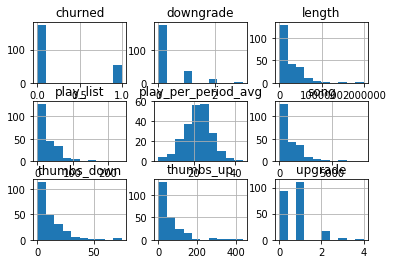

In [46]:
#Merge features into a pyspark dataframe
userinfo=df_churned.groupby("userId").agg({"churned": "sum"})
userinfo_pd=userinfo.toPandas()
play_list_pd=play_list.toPandas()
upgrade_pd=upgrade.toPandas()
downgrade_pd=downgrade.toPandas()
thumbs_up_pd=thumbs_up.toPandas()
thumbs_down_pd=thumbs_down.toPandas()
length_pd=length.toPandas()
song_pd=song.toPandas()
play_count_period=play_count_period.toPandas()

features_df=pd.merge(userinfo_pd, play_list_pd, how='outer', on='userId')
features_df=pd.merge(features_df, upgrade_pd, how='outer', on='userId')
features_df=pd.merge(features_df, downgrade_pd, how='outer', on='userId')
features_df=pd.merge(features_df, thumbs_up_pd, how='outer', on='userId')
features_df=pd.merge(features_df, thumbs_down_pd, how='outer', on='userId')
features_df=pd.merge(features_df, length_pd, how='outer', on='userId')
features_df=pd.merge(features_df, song_pd, how='outer', on='userId')
features_df=pd.merge(features_df, play_count_period, how='outer', on='userId')
features_df.columns = ['userId', 'churned','play_list','upgrade', 'downgrade', 'thumbs_up', 'thumbs_down', 'length', 'song', 'play_per_period_avg']
print(features_df.head())
features_df=features_df.fillna(0)
print(features_df.describe())
print(features_df.head())
hist = features_df.hist()

play_list


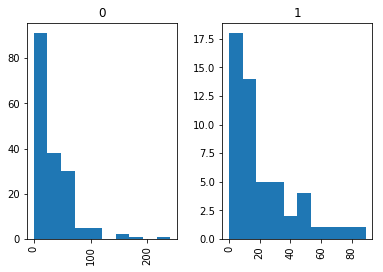

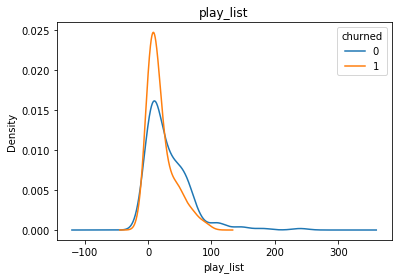

upgrade


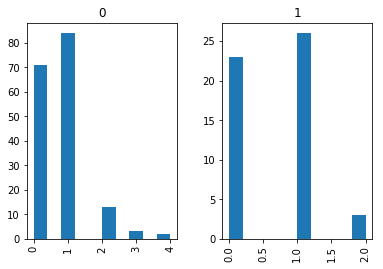

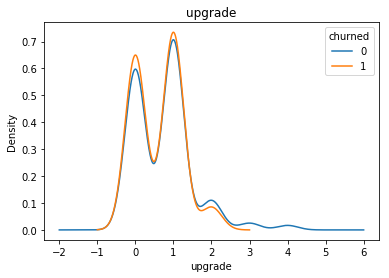

downgrade


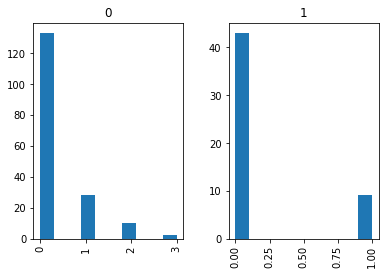

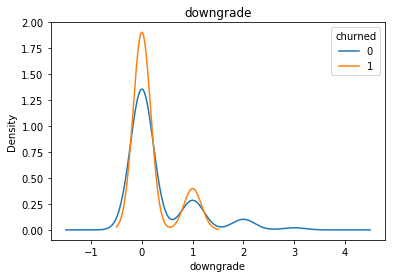

thumbs_up


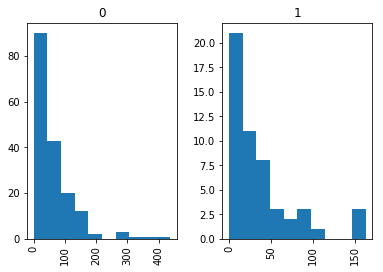

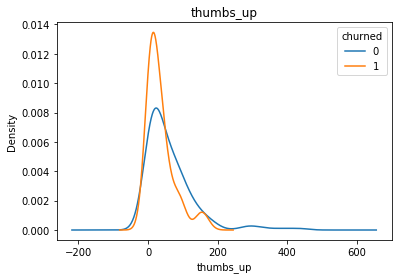

thumbs_down


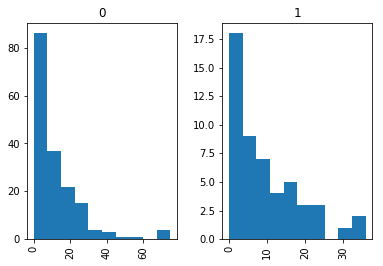

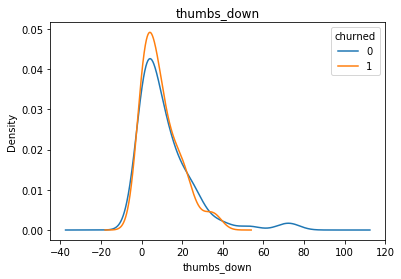

length


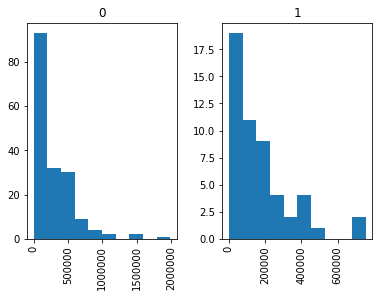

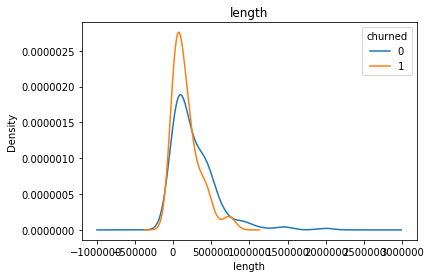

song


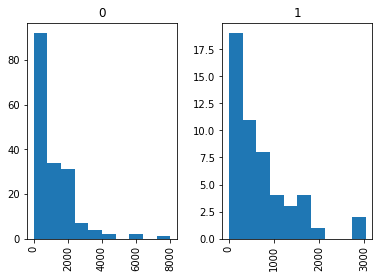

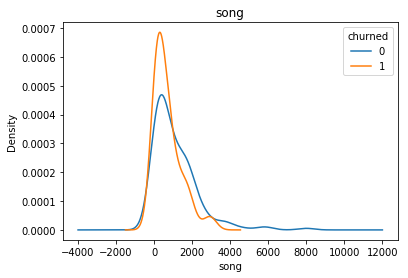

play_per_period_avg


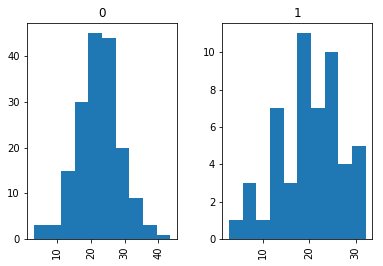

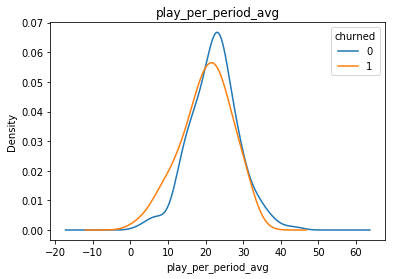

In [47]:
#Histogram and density plots of features
for i in features_df.columns.drop(['churned', 'userId']):
  print(i)
  features_df[i].hist(by=features_df["churned"])
  features_df.pivot(columns='churned',values=i).plot.density()
  plt.xlabel(i)
  plt.title(i)
  plt.show()

In [48]:
#Take a look at feature only dataframe
full_data = spark.createDataFrame(features_df)
features=full_data.drop('userId', 'churned')
print(features.show(10))

+---------+-------+---------+---------+-----------+------------------+----+-------------------+
|play_list|upgrade|downgrade|thumbs_up|thumbs_down|            length|song|play_per_period_avg|
+---------+-------+---------+---------+-----------+------------------+----+-------------------+
|      7.0|    0.0|      0.0|     17.0|        5.0| 66940.89735000003| 275| 22.916666666666668|
|      8.0|    1.0|      0.0|     21.0|        6.0| 94008.87593999993| 387|              19.35|
|      0.0|    0.0|      0.0|      0.0|        0.0|2089.1131000000005|   8|                8.0|
|     52.0|    0.0|      0.0|    100.0|       21.0| 523275.8428000004|2111| 29.319444444444443|
|    118.0|    0.0|      0.0|    171.0|       41.0|1012312.0927899999|4079|   24.4251497005988|
|      5.0|    0.0|      0.0|      7.0|        1.0| 38034.08710000002| 150| 13.636363636363637|
|     72.0|    1.0|      1.0|    163.0|       29.0| 711344.9195400011|2841|  24.92105263157895|
|     59.0|    0.0|      0.0|     81.0| 

In [49]:
#Get features and response columns
full_datadf=full_data.toPandas()
X=full_datadf.drop(columns=['userId', 'churned'])
Y=full_datadf['churned']

#see feature importance by Chi square test
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,Y)
featureScores = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(fit.scores_)],axis=1)
featureScores.columns = ['Properties','Score']  #naming the dataframe columns
print(featureScores.sort_values(by=['Score']))


            Properties         Score
1              upgrade  7.974362e-01
2            downgrade  2.761370e+00
7  play_per_period_avg  8.465556e+00
4          thumbs_down  1.887490e+01
0            play_list  1.906739e+02
3            thumbs_up  4.865217e+02
6                 song  6.574214e+03
5               length  1.651980e+06


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [50]:
#Split data into training and test sets
train, test = full_data.randomSplit([0.8, 0.2], seed=88)
train.select(['churned']).groupby(['churned']).count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  140|
|      1|   48|
+-------+-----+



In [51]:
##Since data is imbalance, we resample the minority group
newRow = train.filter(train.churned == 1)
newRow2 = train.filter(train.churned == 1)
appended = train.union(newRow)
appended = appended.union(newRow2)
appended.select(['churned']).groupby(['churned']).count().show()
train = appended

+-------+-----+
|churned|count|
+-------+-----+
|      0|  140|
|      1|  144|
+-------+-----+



In [52]:
def build_model(classifier, param):      ###reference: https://www.kaggle.com/yukinagae/sparkify-project-churn-prediction
    '''
    input:
    classifier - Machine Learning classifier 
    param - parameters provided
    
    output:
    model - tuned model of chosen classifier
    '''
    assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
    
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='churned', metricName='f1'),
        numFolds=3,
    )
    return model

# Logistic Regression

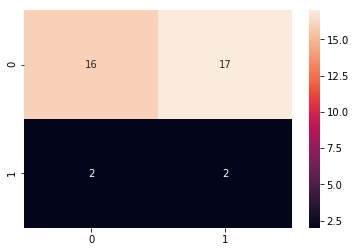

Logistic Regression F1-score:  0.5784198520771412
Logistic Regression accuracy: 0.4864864864864865


In [53]:
#Logistic Regression Training
feature_list = features.columns[:]
lr = LogisticRegression(labelCol="churned", featuresCol="scaled_features")
param = ParamGridBuilder()\
        .addGrid(lr.regParam,[0.1, 0.3])\
        .addGrid(lr.fitIntercept, [False, True])\
        .addGrid(lr.maxIter, [2,3])\
        .build()
model_lr = build_model(lr, param)
model_lr_trained=model_lr.fit(train)
lr_testresult=model_lr_trained.transform(test)

#Plot confusion matrix and print f1 score and accuracy
cm = confusion_matrix(lr_testresult.select(['churned']).toPandas(), lr_testresult.select(['prediction']).toPandas())
sn.heatmap(cm, annot=True)
plt.show()

evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")
lr_testresult=lr_testresult.withColumn('label', lr_testresult.churned)

lr_f1_test = evaluator.evaluate(lr_testresult.select('label','prediction'),{evaluator.metricName: 'f1'})
print('Logistic Regression F1-score: ',lr_f1_test)
lr_accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='churned')
print ('Logistic Regression accuracy:', lr_accuracy.evaluate(lr_testresult))

# Random Forest

+-------+-----+
|churned|count|
+-------+-----+
|      0|   33|
|      1|    4|
+-------+-----+



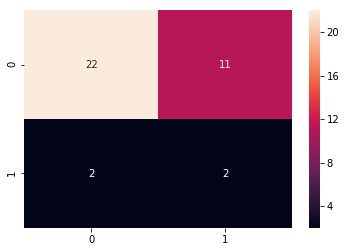

Random Forest F1-score:  0.7139151535436365
Random Forest accuracy: 0.6486486486486487


In [54]:
#Random Forest Training
rf = RandomForestClassifier(labelCol="churned", featuresCol="scaled_features")
paramrf = ParamGridBuilder()\
        .addGrid(rf.numTrees, range(5, 65, 6)) \
        .build()

model_rf = build_model(rf, paramrf)
model_rf_trained = model_rf.fit(train)
rf_testresult = model_rf_trained.transform(test)

#Plot confusion matrix and print f1 score and accuracy
rf_testresult.select(['churned']).groupby('churned').count().show()
cm = confusion_matrix(rf_testresult.select(['churned']).toPandas(), rf_testresult.select(['prediction']).toPandas())
sn.heatmap(cm, annot=True)
plt.show()

rf_testresult=rf_testresult.withColumn('label', rf_testresult.churned)
rf_f1_test = evaluator.evaluate(rf_testresult.select('label','prediction'),{evaluator.metricName: 'f1'})
print('Random Forest F1-score: ',rf_f1_test)
rf_accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='churned')
print ('Random Forest accuracy:', rf_accuracy.evaluate(rf_testresult))

# Gradient Boosted Trees

+-------+-----+
|churned|count|
+-------+-----+
|      0|   33|
|      1|    4|
+-------+-----+



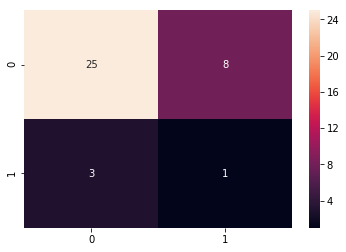

Gradient Boosted Trees F1-score:  0.7476909444122559
Gradient Boosted Trees accuracy: 0.7027027027027027


In [55]:
#Gradient Boosted Trees
gbt = GBTClassifier(labelCol="churned", featuresCol="scaled_features")
paramgbt = ParamGridBuilder()\
        .addGrid(gbt.maxDepth, [2, 5])\
        .addGrid(gbt.maxIter, [5, 10])\
        .build()

model_gbt = build_model(gbt, paramrf)
model_gbt_trained = model_gbt.fit(train)
gbt_testresult = model_gbt_trained.transform(test)

#Plot confusion matrix and print f1 score and accuracy
gbt_testresult.select(['churned']).groupby('churned').count().show()
cm = confusion_matrix(gbt_testresult.select(['churned']).toPandas(), gbt_testresult.select(['prediction']).toPandas())
sn.heatmap(cm, annot=True)
plt.show()

gbt_testresult=gbt_testresult.withColumn('label', rf_testresult.churned)
gbt_f1_test = evaluator.evaluate(gbt_testresult.select('label','prediction'),{evaluator.metricName: 'f1'})
print('Gradient Boosted Trees F1-score: ',gbt_f1_test)
gbt_accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='churned')
print ('Gradient Boosted Trees accuracy:', rf_accuracy.evaluate(gbt_testresult))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.